In [416]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import scipy as sp

import pandas as _pd

import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import simps,trapz
import scipy.constants as _con

## Helper functions 
From Jeff

In [417]:
# constants
k = _con.k  # Boltzmann constant (J/K)
c = _con.c  # Speed of light (m/s)
h = _con.h  # Planck's Constant (J-s)

# physics utility functions
def n_occ (T,v):
    """Photon mode occupation number of a black body of temperature T at frequency v"""
    return 1./(np.exp(h*v/(k*T))-1)

def IBlackBody (T, v, pol=False):
    """Planck's Law spectral radiance - radiated power (in the normal direction) per steradian
    per square meter per Hertz at frequency v - for a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    polfactor = 1 if pol else 2
    return polfactor * h/(c**2)*(v**3)*n_occ(T,v)

def PBBSingleModed (T, v1=0, v2=np.inf, pol=False):
    """Planck's Law radiative power received by an ideal single-moded
    receiver sensitive over frequency band [v1,v2] observing a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    (out,err) = quad(lambda v: IBlackBody(T,v,pol=pol)*(c/v)**2, v1, v2)
    return out

def NEP_photon (T,eta,v1=0,v2=np.inf, pol=False, narrow=False):
    """Photon NEP [W/rtHz] for a noiseless detector observing temperature T
    with quantum efficiency eta over a frequency band [v1,v2].
    Defined with an integral to hander wider bands; faster with narrow=True."""
    polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
    if narrow:
        v0 = (v1+v2)/2.
        dv = (v2-v1)
        return np.sqrt(2*polfactor)*h*v0*np.sqrt(dv*eta*n_occ(T,v0)*(1+eta*n_occ(T,v0)))
    else:
        integrand = lambda v: eta*(h*v)**2*n_occ(T,v) + (eta*h*v*n_occ(T,v))**2
        # integrate and incorporate the factor of 2 from NEP definition
        return np.sqrt(2*polfactor*quad(integrand,v1,v2)[0])

In [137]:
class amModel:
# Encapsulates an am atmosphere model
# Columns: f (GHz), tx , Tb (K), I (watt*cm-2*GHz-1*sr-1)
# tx: transmissionmittance
# Tb: Planck brightness temperature (redundant with I)
# I: Spectral radiance (unpolarized)
    def __init__(self, filename, label=None):
        '''Initialize a new am model (code assumes we know the units!!!)'''
        self.atmo = _pd.read_csv(filename,header=None, comment='#', sep=' ', names=['vGHz','tx','Tb','Trj','I'])
        self.atmo['n'] = self.atmo['I']*1e-5*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
        self.label=label
    def I(self,v):
        '''Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return np.interp(v/1e9,self.atmo['vGHz'],self.atmo['I'])*1e-5 # intensity in W/m2/Hz/sr (dual-pol)
    def I_func(self):
        '''Return a Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return interpolate.interp1d(self.atmo['vGHz']*1e9,self.atmo['I']*1e-5) # intensity in W/m2/Hz/sr (dual-pol)
    
    def n(self,v):
        '''Mode occupation number '''
        return self.I(v)*c**2/(2*h*v**3) # mode occupation number as a function of frequency
    def P(self,v1,v2,pol=False):
        """Returns the unobstructed single-moded power from the atmosphere model in a given band"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 2 if pol else 1 # Iatm is unpolarized, so we divide by 2 for single-pol
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return trapz(temp['I']*1e-5 * (c/(temp['vGHz']*1e9))**2,x=temp['vGHz']*1e9)/polfactor
    def NEP(self,eta,v1,v2,pol=False):
        """Atmospheric NEP associated with a given band observed with efficiency eta"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
        temp = self.atmo[(self.atmo['vGHz']>=v1/1e9) & (self.atmo['vGHz']<v2/1e9)]
        return _np.sqrt( polfactor * trapz( 
            (h*temp['vGHz']*1e9)**2*eta*temp['n'] + (eta*h*temp['vGHz']*1e9*temp['n'])**2,
            x=temp['vGHz']*1e9))

#### Optical Elements

In [487]:
class Element:
    """
    The base class for all optical elements in the stack.
    """
    def __init__(self, name, emissivity=None, emis_func=None, self_source=None, \
                 refl_source=None,\
                 spillage=None, spill_func=None, spill_source=None,):
        self.name = name
        self.self_source = self_source
        self.spillage = spillage
        self.spill_func = spill_func
        self.spill_source = spill_source
        # self.refl  = reflection
        self.refl_source = refl_source
        self.efficiency = None
        self.emissivity = emissivity
        self.emis_func = emis_func

    def emis(self, v):
        if self.emissivity is not None:
            return self.emissivity * np.ones(v.shape)
        else:
            return self.emis_func(v)
        
    def spill(self, v):
        if self.spillage is not None:
            return self.spillage * np.ones(v.shape)
        else:
            return self.spill_func(v)


class Mirror(Element):
    """
    A subclass for Mirror which has transmission equals to 0
    """
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)

    def transfer(self, v):
        return 1 - self.emis(v)
    
    def __copy__(self):
        return Mirror(self.name, kwargs=self.kwargs)
    

class Grating(Mirror):
    """
    A subclass for Grating 
    """
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)

    def transfer(self, v):
        return 1 - self.emis(v)
        

class Filter(Element):
    """
    A subclass of Element that adds specific properties for a filter,
    """
    def __init__(self, name, transmission=None, trans_func=None, **kwargs):
        super().__init__(name, **kwargs)
        self.transmission = transmission
        self.trans_func = trans_func
    
    def trans(self, v):
        if self.transmission is not None:
            return self.transmission * np.ones(v.shape)
        else:
            return self.trans_func(v)
        
    def refl(self, v):
        refl = 1 - self.trans(v) - self.emis(v) 
        if np.any(refl<0):
            raise ValueError("Can't have negative reflectivity.")
        return refl
        
    def transfer(self, v):
        return self.trans(v)
    

class Source(Element):
    """
    A subclass of Element that encapsulates all sources in the model and provides a method to get the
    radiance of the source.
    """
    def __init__(self, name, ):
        super().__init__(name)


class BB(Source):
    def __init__(self, name, T=300):
        super().__init__(name)
        self.T = T 

    def get_radiance(self, v):
        return IBlackBody(self.T, v, pol=False)
        
        
class Atmo(Source):
    def __init__(self, name, filename=None, rad_func=None):
        super().__init__(name)
        if filename is not None:
            self.atmo = _pd.read_csv(filename, header=None, comment='#', sep=' ', names=['vGHz','tx','Tb','Trj','I'])
            self.atmo['n'] = self.atmo['I']*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
    
    def I(self,v):
        '''Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return np.interp(v/1e9,self.atmo['vGHz'],self.atmo['I']) # intensity in W/m2/Hz/sr (dual-pol)
    
    def I_func(self):
        '''Return a Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return interpolate.interp1d(self.atmo['vGHz']*1e9,self.atmo['I']) # intensity in W/m2/Hz/sr (dual-pol)

    def get_radiance(self, v):
        return self.I_func()(v)


class Functions():
    def __init__(self, v=None, prop=None, fill=0):
        self.func = interpolate.interp1d(v, prop, fill_value=fill, bounds_error=False)


def gaussian(x, mu=0, sig=1):
    return np.exp(-(x - mu)**2 / (2 * sig**2))


class PixelBandpass():
    def __init__(self, pixelNu=None):
        if pixelNu is not None:
            self.n = len(pixelNu)-1
            self.pixelNu = pixelNu
            self.nuCenter = (self.pixelNu[1:] + self.pixelNu[:-1])/2

    
    def getBandpass(self,nu):
        pixelBandpass = np.zeros((self.n, len(nu)))
        FWHMfactor = 2*(2*np.log(2))**0.5  # FWHM/sigma
        
        for i in range(self.n):
            pixelBandpass[i] = gaussian(nu, mu=self.nuCenter[i], sig=np.abs(self.nuCenter[i]-self.pixelNu[i])*2/FWHMfactor)
        return pixelBandpass

        

class OpticalStack:
    """
    The base class for a optical system, consists of multiple optical elements.
    """
    def __init__(self, stack=None, sources=None):
        self.stack = stack
        self.sources = sources
        self.n_source = len(self.sources)
        self.n_layers = len(self.stack)
        self.entendue = None
        self.efficiency = None

    def effiVec(self, source, v):
        effiVec = np.zeros((self.n_source, len(v)))
        effiVec[self.sources.index(source),:] = 1
        return effiVec
    
    def eff_cal(self, v):
    # Initialize the efficiency vector with 100% efficiency at the first source
        self.efficiency = np.zeros((self.n_source, len(v)))
        self.efficiency[0,:] = 1

        # Calculate the efficiency at each layer of the stack
        for layer in self.stack:
            # Calculate the contribution from self-source, spill and remaining power
            self_efficiency = layer.emis(v) * self.effiVec(layer.self_source, v) 
            spill_efficiency = layer.transfer(v) * layer.spill(v) * self.effiVec(layer.spill_source, v)
            remaining_efficiency = layer.transfer(v) * (1 - layer.spill(v)) * self.efficiency

            if isinstance(layer,Filter):
                refl_efficiency = layer.refl(v) * self.effiVec(layer.refl_source, v)
            else:
                refl_efficiency = np.zeros((self.n_source, len(v)))

            # Update the efficiency vector with the new values
            self.efficiency = self_efficiency + spill_efficiency + remaining_efficiency + refl_efficiency

            # Store the efficiency for this layer
            layer.efficiency = self.efficiency

        # Return the overall efficiency of the stack
        return self.efficiency
        
    
    def radiance(self, v, source=None):
        radiance = np.zeros(v.shape)

        # if source is not specified, calculate the total radiance
        if source is None:
            for efficiency, source in zip(self.efficiency, self.sources):
                radiance += efficiency * source.get_radiance(v)
        
        # if source is specified, calculate the radiance from this source
        else:
            source_index = self.sources.index(source)
            radiance = self.efficiency[source_index] * source.get_radiance(v)

        return radiance

    def loadingOG(self, v, source=None, R=250):
        if source is None:
            loading = self.radiance(v) * (c/v)**2 * v/R 

        else:
            loading = self.radiance(v, source=source) * (c/v)**2 * v/R 

        return loading

    
    def loading(self, v, source=None, bandpass=None):
        if isinstance(bandpass, PixelBandpass):
            loading = np.zeros(bandpass.n)
            pixelBandpass = bandpass.getBandpass(v)
            radiance = self.radiance(v)
            for i in range(bandpass.n):
                loading[i] = np.sum(pixelBandpass[i]*radiance) * (c/bandpass.nuCenter[i])**2 \
                            * (v[1]-v[0])
            return loading
        else:
            raise TypeError("bandpass needs to be a PixelBandpass object.")



In [139]:
# create pandas data frame of spill / transmission
# first, geometric spill only (eyeballed from Isaac's plots for wide, narrow from LW (73,64))
# added some emissivity to each reflecting surface
# zeroed out everything out of band past the slit
spill = _pd.DataFrame(
    {'Stage':['camera','grating','collimator','coll fold','slit mirror','slit','offner out',\
                                'offner m3','offner m2','offner m1','offner in','vcs1','vcs2',\
                                  'window','secondary','primary','obscuration','spider'],
    'Tspill':[Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,Toptics,\
              Toptics,Toptics,Tvcs1,Tvcs2,Twin,Tprimary,Tprimary,Tprimary,Tprimary],
    'SpillWide':[0.18,0.06,0.17,0.34,0.17,0.08,0,0,0,0,0,0,0,0,0,0,0,0],
    'SpillNarrow':[epsOptics  ,0.1032 + (1-fBlaze), epsOptics ,epsOptics   ,epsOptics,\
                    0.1615*fBlaze,epsOptics ,epsOptics   ,0.1734*fBlaze,epsOptics , \
                        epsOptics ,epsVCS1,epsVCS2,epsWin,fBlaze*0.0513*(1-fSkySecondary)\
                          +epsPrimary,fBlaze*0.025*(1-fSkyPrimary)+epsPrimary,\ 
                          fBlaze*0.0013*(1-fSkyObscuration),fBlaze*0.0077*(1-fSkySpider)]})
effSky = 1-spill.SpillNarrow.sum()

SyntaxError: unexpected character after line continuation character (<ipython-input-139-80e31325f61a>, line 15)

### Functions for propeties of the material

#### HDPE

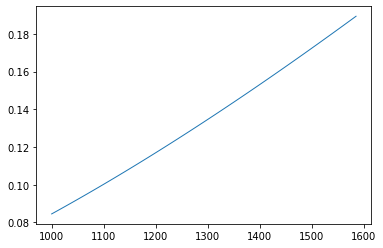

In [419]:
def HDPE_emis(thickness=1., ):
    """
    v in Hz
    thickness in metter
    """
    a = 1.2e-3
    b = 1.882

    def func(v):
        return 1-np.exp(-1*a* (v/1e9/29.9792458)**b * thickness*100)
    
    return func


v = np.logspace(3,3.2)

plt.plot(v, HDPE_emis(thickness=1e-3)(v*1e9))



#### UHMWPE

In [420]:
def UHMWPE_emis(thickness=1.):
    """
    v in Hz
    thickness in metter
    """
    UPE = np.loadtxt('../plastic/UHMWPE_alpha.tsv').T
    alpha = interpolate.interp1d(UPE[0]*1e9, UPE[1], bounds_error=False)

    def func(v):
        return 1-np.exp(-1*alpha(v) * thickness*100)
    
    return func

def Plastic_emis(alpha=None, thickness=1.):
    """
    v in Hz
    thickness in metter
    """

    def func(v):
        return 1-np.exp(-1*alpha * thickness*100)
    
    return func

def PP_emis(thickness=1.):
    """
    v in Hz
    thickness in metter
    """
    PP = np.loadtxt('../plastic/PP_abs_eff.tsv').T
    alpha = interpolate.interp1d(PP[0]*1e9, PP[1], bounds_error=False)

    def func(v):
        return 1-np.exp(-1*alpha(v) * thickness*100)
    
    return func


In [421]:
LWGrating = np.loadtxt("../gratings/TIM_LW_Sawtooth26deg_Efficiency.tsv", skiprows=3)
SWGrating = np.loadtxt("../gratings/TIM_SW_Sawtooth26deg_Efficiency.tsv", skiprows=3)

blazeEff = Functions(v=np.concatenate((c/LWGrating[:,0]/1e-6, c/SWGrating[:,0]/1e-6)), \
                     prop=np.concatenate((1.-LWGrating[:,1], 1.-SWGrating[:,1])), fill=1)


### System parameters

In [460]:
# temperature
Tprimary = 250
Tvcs2    = 175
Tvcs2f1  = 220
Tvcs1    = 65
Tvcs1f1  = 100

Tcold   = 4.8
Tcoldf1 = 10
Tfpu    = 0.25


# emissivity
epsPrimary = 0.01
epsWin  = 0.005
epsVCS2 = 0.005
epsVCS1 = 0.005
epsF4k  = 0.005
epsCold = 0.005



### Optical stack

In [515]:
bbWarm = BB('Warm', T=Tprimary)

bbVCS2 = BB('VCS2', T=Tvcs2)
bbVCS2f1 = BB('VCS2 Filter1', T=Tvcs2f1)

bbVCS1 = BB('VCS1', T=Tvcs1)
bbVCS1f1 = BB('VCS1 Filter1', T=Tvcs1f1)

bbCold = BB('4K', T=Tcold)
bb4kf1 =  BB('4K Filter1', T=Tcoldf1)

bbFPU = BB('250mK', T=Tfpu)


Ant37  = '../tim-inst_modl/atmospheric_models/models/Antarctic_DJF_34km_45deg_1.0.out'
skyNoise = Atmo('Sky Scattering', filename = Ant37 )
sky      = Atmo('Sky', filename = Ant37)


wm1 = Mirror('Primary', emissivity=epsPrimary, self_source=bbWarm, \
            spillage=0.01, spill_source=skyNoise)

wm2 = Mirror('Secondary', emissivity=epsPrimary, self_source=bbWarm, \
            spillage=0.01, spill_source=skyNoise)

w1 = Filter('Window', emis_func=UHMWPE_emis(thickness=0.8e-3), self_source=bbWarm, \
            refl_source=bbVCS2, transmission=0.95, spillage=0.002, spill_source=bbWarm)

fw1 = Filter('PP scattering', emis_func=Plastic_emis(alpha=0.6, thickness=0.5*0.5e-3), self_source=bbWarm, \
            refl_source=bbVCS2,transmission=0.96, spillage=0.002, spill_source=bbWarm)

fv21 = Filter('VCS2 Filter', emis_func=Plastic_emis(alpha=0.6, thickness=4e-6), self_source=bbVCS2f1, \
            refl_source=bbVCS1,transmission=0.96, spillage=0.002, spill_source=bbWarm)

fv22 = Filter('VCS2 Filter', emis_func=Plastic_emis(alpha=0.6, thickness=4e-6), self_source=bbVCS2f1, \
            refl_source=bbVCS1,transmission=0.96, spillage=0.00, spill_source=bbWarm)

fv11 = Filter('VCS1 Filter1', emis_func=Plastic_emis(alpha=0.6, thickness=4e-6), self_source=bbVCS1f1, \
            refl_source=bbCold,transmission=0.96, spillage=0.01, spill_source=bbVCS2)

f4k = Filter('4K Filter', emis_func=Plastic_emis(alpha=0.6, thickness=4e-6), self_source=bb4kf1, \
            refl_source=bbCold, transmission=0.96, spillage=0.00, spill_source=bbVCS1)

cm1 = Mirror('Offner', emissivity=epsCold, self_source=bbCold, \
            spillage=0.15, spill_source=bbCold)

cm2 = Mirror('Offner', emissivity=epsCold, self_source=bbCold, \
            spillage=0.15, spill_source=bbCold)

cm3 = Mirror('Offner', emissivity=epsCold, self_source=bbCold, \
            spillage=0.05, spill_source=bbCold)

cm4 = Mirror('Offner', emissivity=epsCold, self_source=bbCold, \
            spillage=0.06, spill_source=bbCold)

cm5 = Mirror('Collimator', emissivity=epsCold, self_source=bbCold, \
            spillage=0.04, spill_source=bbCold)

cm6 = Mirror('Collimator', emissivity=epsCold, self_source=bbCold, \
            spillage=0.04, spill_source=bbCold)

cm7 = Mirror('Collimator', emissivity=epsCold, self_source=bbCold, \
            spillage=0.04, spill_source=bbCold)

cm8 = Grating('Grating', emissivity=epsCold, self_source=bbCold, \
            spill_func=blazeEff.func, spill_source=bbCold)  

cm9 = Mirror('Camera Mirror', emissivity=epsCold, self_source=bbCold, \
            spillage=0.10, spill_source=bbCold)

f025k1 = Filter('250mK Filter', emissivity=epsF4k, self_source=bb4kf1, \
            refl_source=bbFPU,transmission=0.96, spillage=0.02, spill_source=bbCold)

f025k2 = Filter('250mK Filter', emissivity=epsF4k, self_source=bb4kf1, \
            refl_source=bbFPU,transmission=0.96, spillage=0.00, spill_source=bbCold)

layers = [wm1,wm2,w1,fw1,fv21,fv22,fv11,f4k,cm1,cm2,cm3,cm4,cm5,cm6,cm7,cm8,cm9,f025k1,f025k2]
sources = [sky,skyNoise,bbWarm,bbVCS2,bbVCS2f1,bbVCS1,bbVCS1f1,bbCold,bb4kf1,bbFPU]

stack = OpticalStack(layers,sources)


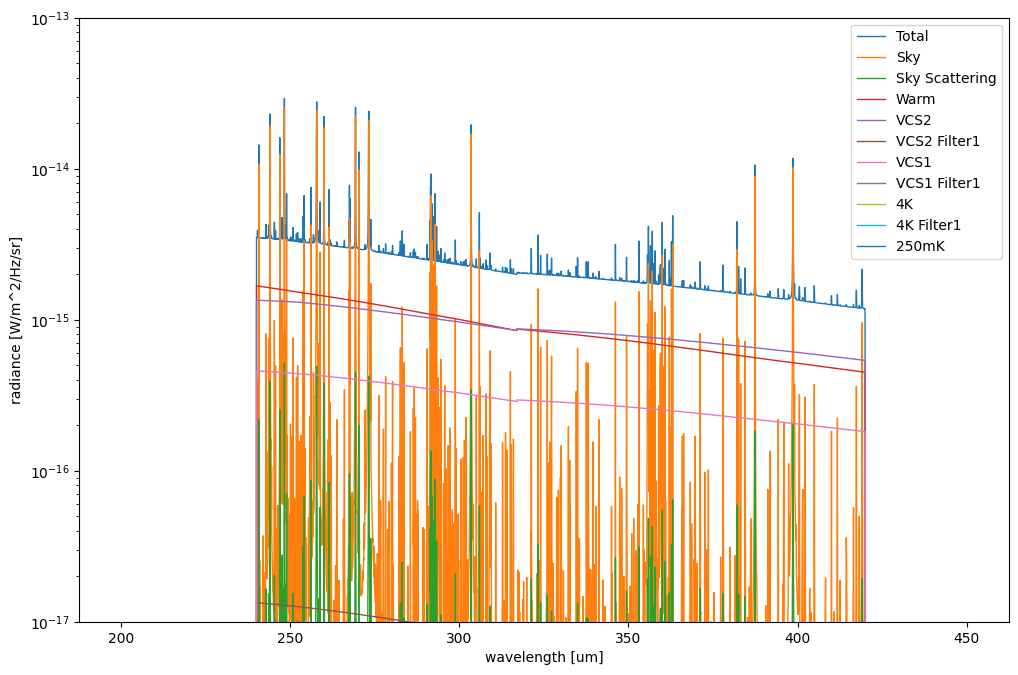

In [516]:
nu_min = c/450e-6
nu_max = c/200e-6
nu_n   = 4000

nu = np.linspace(nu_min, nu_max, nu_n)

lamb = c/nu
eff = stack.eff_cal(c/lamb)


plt.figure(figsize=(12,8), dpi=100)

plt.plot(lamb/1e-6, stack.radiance(c/lamb,),label='Total')

for source in sources:
    plt.plot(lamb/1e-6, stack.radiance(c/lamb,source=source), label=source.name)


plt.xlabel('wavelength [um]')
plt.ylabel('radiance [W/m^2/Hz/sr]')

plt.ylim([1e-17,1e-13])
plt.yscale("log")
plt.legend()

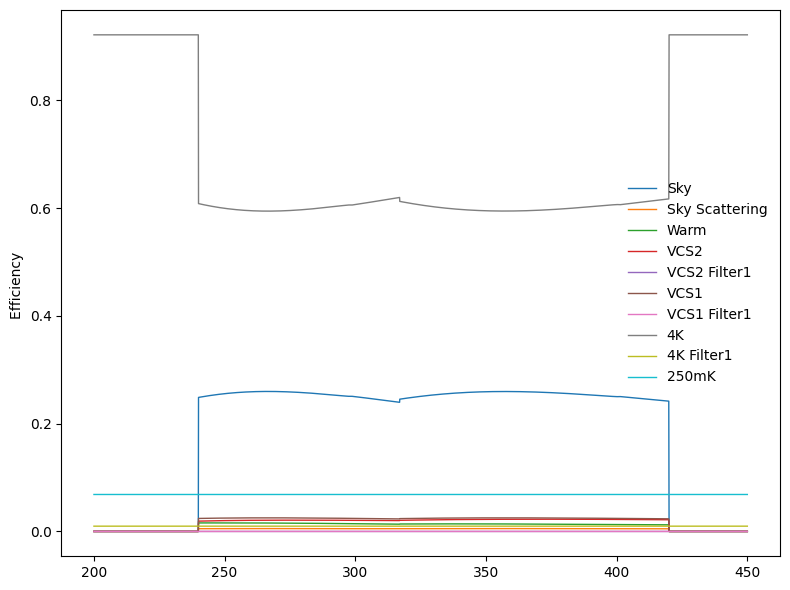

In [517]:
plt.figure(figsize=(8,6), dpi=100)

for i,source in enumerate(stack.sources):
    plt.plot(lamb/1e-6, stack.efficiency[i], label=source.name)

# plt.xscale("log")
# plt.yscale("log")

plt.ylabel("Efficiency ")
plt.legend(frameon=0)
plt.tight_layout()

In [518]:
SWlambMin = 240e-6
SWlambMax = 317e-6
LWlambMin = 317e-6
LWlambMax = 420e-6

SW_n    = 63*2
LW_n    = 63*2

Rfactor = 2.2

SWdetectors = np.logspace(np.log10(c/SWlambMax),np.log10(c/SWlambMin), num=SW_n+1)
LWdetectors = np.logspace(np.log10(c/LWlambMax),np.log10(c/LWlambMin), num=LW_n+1)

LWpixelBandpass = PixelBandpass(LWdetectors)
SWpixelBandpass = PixelBandpass(SWdetectors)

LWloading = stack.loading(c/lamb, bandpass=LWpixelBandpass)
SWloading = stack.loading(c/lamb, bandpass=SWpixelBandpass)



(385.0, 400.0)

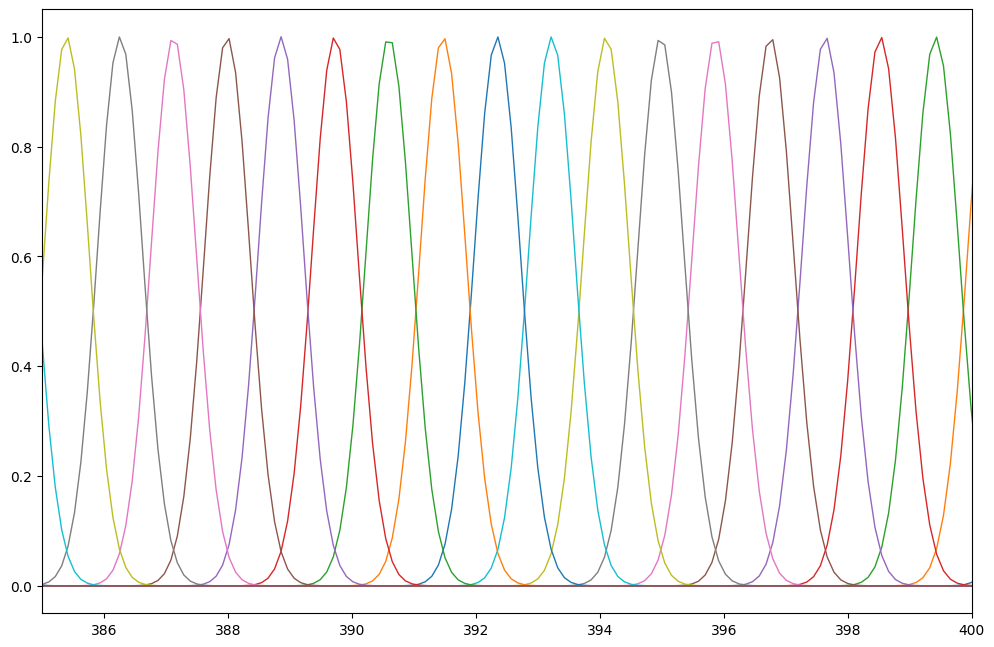

In [519]:


bandpasses = LWpixelBandpass.getBandpass(c/lamb)

plt.figure(figsize=(12,8), dpi=100)

for band in bandpasses:
    plt.plot(lamb*1e6, band)


plt.xlim(385,400)
    

(300.0, 430.0)

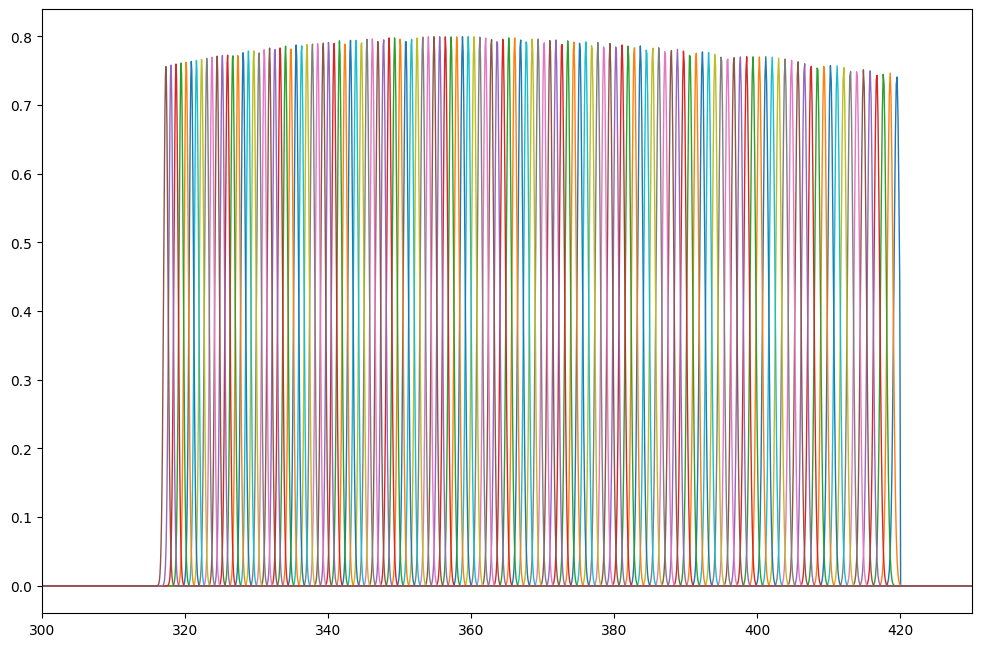

In [512]:

bandpasses = LWpixelBandpass.getBandpass(c/lamb)

plt.figure(figsize=(12,8), dpi=100)

for band in bandpasses:
    plt.plot(lamb*1e6, band*(1-blazeEff.func(c/lamb)))


plt.xlim(300,430)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


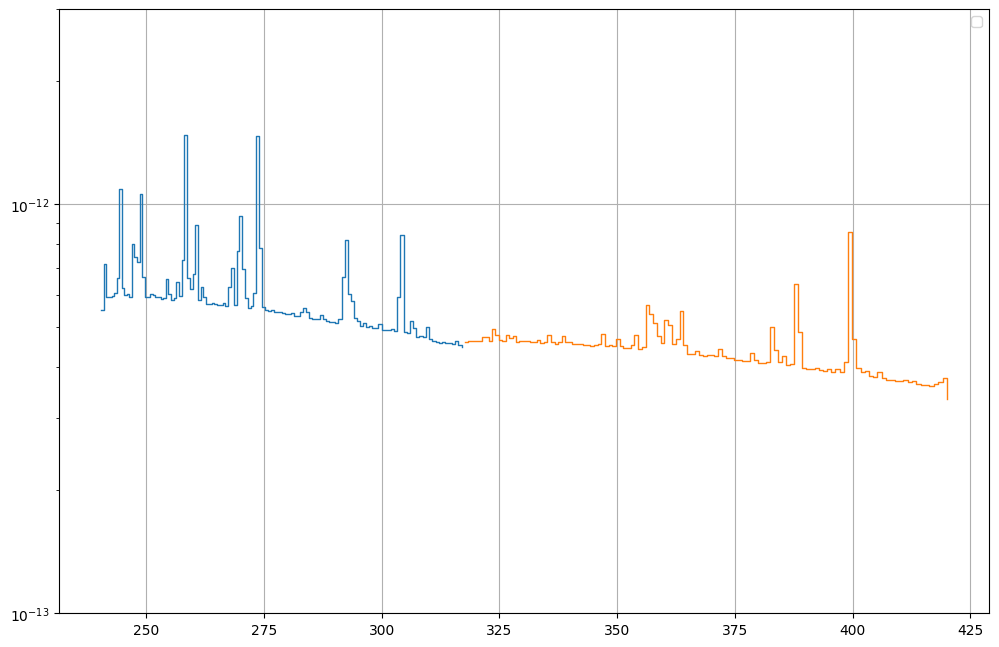

In [520]:
plt.figure(figsize=(12,8), dpi=100)

plt.step(c/SWdetectors[:-1]*1e6, SWloading)
plt.step(c/LWdetectors[:-1]*1e6, LWloading)


plt.ylim([1e-13,3e-12])
plt.yscale("log")
plt.legend()
plt.grid()

plt.show()

In [521]:
eff = []

for item in stack.stack:
    eff.append((np.mean(item.efficiency[:,800:3200], axis=1)))

eff = np.array(eff)

effTable = _pd.DataFrame(eff, index=[item.name for item in stack.stack], columns=[source.name for source in sources])
effTable['Total'] = effTable.sum(axis=1)

effTable

,Sky,Sky Scattering,Warm,VCS2,VCS2 Filter1,VCS1,VCS1 Filter1,4K,4K Filter1,250mK,Total
Primary,0.980100,0.009900,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.0
Secondary,0.960596,0.019603,0.019801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.0
Window,0.910741,0.018586,0.034508,0.036165,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.0
PP scattering,0.872563,0.017806,0.049870,0.059761,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.0
VCS2 Filter,0.835985,0.017060,0.049699,0.057256,0.000240,0.039760,0.000000,0.000000,0.000000,0.0000,1.0
VCS2 Filter,0.802546,0.016378,0.047711,0.054966,0.000470,0.077930,0.000000,0.000000,0.000000,0.0000,1.0
VCS1 Filter1,0.762739,0.015565,0.045345,0.061839,0.000447,0.074064,0.000240,0.039760,0.000000,0.0000,1.0
4K Filter,0.732230,0.014943,0.043531,0.059366,0.000429,0.071102,0.000230,0.077930,0.000240,0.0000,1.0
Offner,0.619283,0.012638,0.036816,0.050209,0.000363,0.060134,0.000195,0.220159,0.000203,0.0000,1.0
Offner,0.523759,0.010688,0.031137,0.042464,0.000307,0.050859,0.000165,0.340449,0.000172,0.0000,1.0


ValueError: x and y must have same first dimension, but have shapes (1,) and (6,)

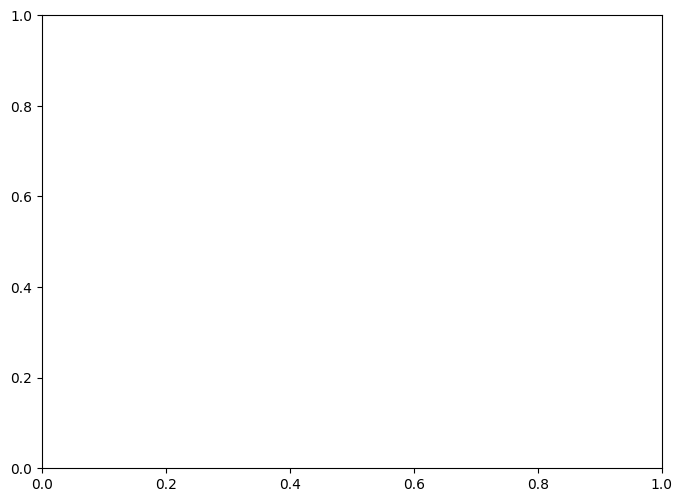

In [202]:
plt.figure(figsize=(8,6), dpi=100)

for i, layer in enumerate(stack.stack):
    plt.plot(i, layer.efficiency[i, i], label=sources[i].name)

# plt.xscale("log")
# plt.yscale("log")

plt.ylabel("Efficiency ")
plt.legend(frameon=0)
plt.tight_layout()

In [134]:
plt.figure(figsize=(8,6), dpi=100)

plt.plot(lamb*1e6,loading, label='Total')

for item in stack.stack[:-1]:
    plt.plot(lamb*1e6, lamb**2*item.radiance_add*c/lamb/200, label=item.name)

# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Wavelength [um]")
plt.ylabel("Power [W]")
plt.legend(frameon=0)
plt.tight_layout()

NameError: name 'loading' is not defined

<Figure size 800x600 with 0 Axes>